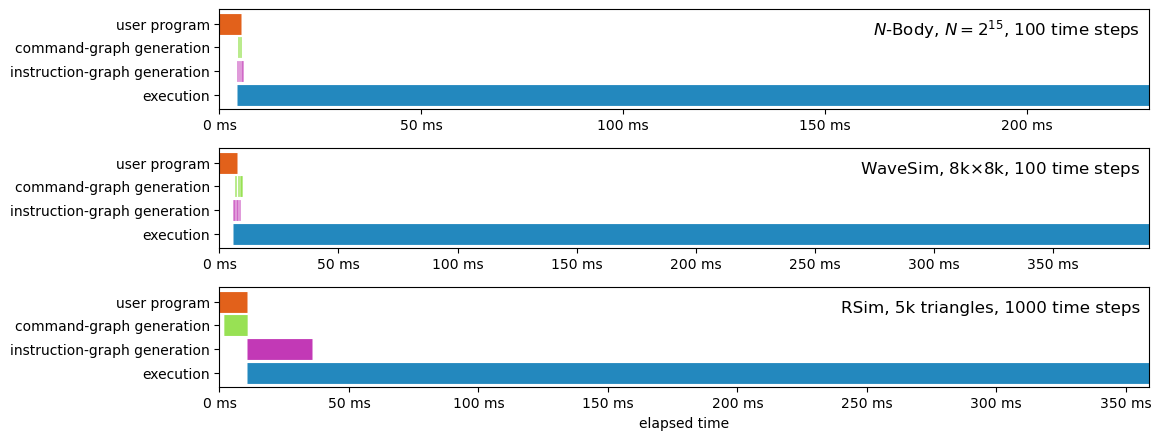

In [44]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from math import inf
from os.path import join

color_map = {
    'user': '#e2611b',
    'cdag': '#77d81d',
    'idag': '#c239b6',
    'execute': '#2388be',
}

yaxis_labels = {
    'user': 'user program',
    'cdag': 'command-graph generation',
    'idag': 'instruction-graph generation',
    'execute': 'execution',
}

def read_timestamp_file(filename):
    try:
        with open(filename) as f:
            return int(f.read())
    except (FileNotFoundError, ValueError):
        return 0

def read_string_file(filename):
    try:
        with open(filename) as f:
            return f.read()
    except (FileNotFoundError, ValueError):
        return ''

fig, axes = plt.subplots(nrows=3, figsize=(12, 4.9), gridspec_kw=dict(hspace=0.4))

for row, experiment in enumerate(['nbody', 'wave_sim', 'rsim_small']):
    ax = axes[row]

    input_files = [
        ('runtime', 'profile.runtime.csv'),
        ('scheduler', 'profile.scheduler.csv'),
        ('executor', 'profile.executor.csv')
    ]

    with open(join(experiment, 'profile.cmdline'), 'rb') as f:
        args = f.read().replace(b'\0', b' ').decode('utf-8')

    global_start = read_timestamp_file(join(experiment, 'profile.start.txt'))
    global_stop = read_timestamp_file(join(experiment, 'profile.stop.txt'))
    title = read_string_file(join(experiment, 'title.txt'))

    series = []
    for label, file in input_files:
        df = pd.read_csv(join(experiment, file))
        start = df['start']
        stop = df['stop']
        if 'tag' in df.columns:
            for tag in df.tag.unique():
                df_tag = df[df.tag == tag]
                series.append((tag, df_tag.start, df_tag.stop))
        else:
            series.append((label, df.start, df.stop))

    for i, (label, start, stop) in enumerate(series):
        start = (start - global_start) / 1e6
        stop = (stop - global_start) / 1e6
        colors = color_map[label]
        ax.hlines(np.full(start.shape, i), start, stop, colors=colors, linewidth=15)
    ax.set_ylim(len(series) - 0.4, -0.6)
    ax.set_yticks(range(len(series)))
    ax.set_yticklabels([yaxis_labels[s[0]] for s in series])
    if global_stop != global_start:
        ax.set_xlim(0, (global_stop - global_start) / 1e6)
    if row == 2:
        ax.set_xlabel('elapsed time')
    ax.set_title(title, x=0.99, y=1.0, pad=-18, ha='right')
    ax.xaxis.set_major_formatter('{x:.0f} ms')
    # ax.set_title(f'{title}\n{args}')

fig.savefig(f'profile.pdf', bbox_inches='tight', dpi=300)
